Epoch 1, Step 0, Gen Loss: 0.7101755142211914, Disc Loss: 1.3755247592926025
Epoch 1, Step 100, Gen Loss: 2.1167588233947754, Disc Loss: 0.26538071036338806


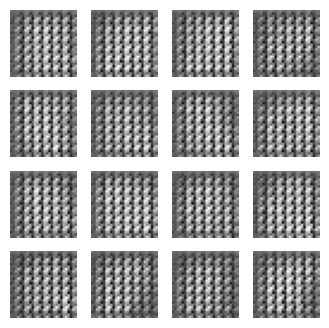

Epoch 2, Step 0, Gen Loss: 4.191201210021973, Disc Loss: 0.07807660847902298
Epoch 2, Step 100, Gen Loss: 3.0935263633728027, Disc Loss: 0.26832252740859985


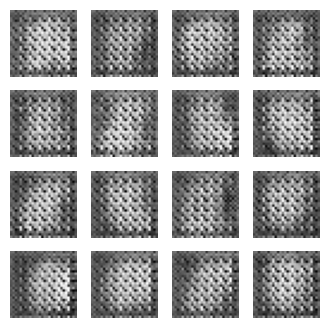

Epoch 3, Step 0, Gen Loss: 1.9583947658538818, Disc Loss: 0.7406272888183594
Epoch 3, Step 100, Gen Loss: 1.896869421005249, Disc Loss: 0.6642892360687256


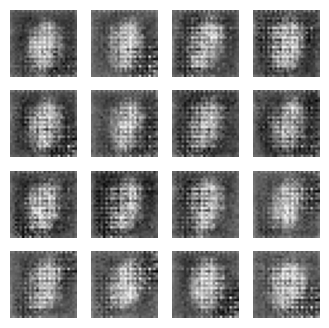

Epoch 4, Step 0, Gen Loss: 1.7618688344955444, Disc Loss: 0.49035149812698364
Epoch 4, Step 100, Gen Loss: 1.2712247371673584, Disc Loss: 0.7393198609352112


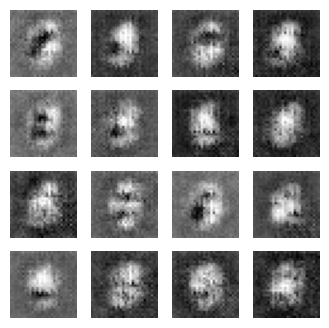

Epoch 5, Step 0, Gen Loss: 1.0627037286758423, Disc Loss: 0.8092936277389526
Epoch 5, Step 100, Gen Loss: 1.0915625095367432, Disc Loss: 0.9137514233589172


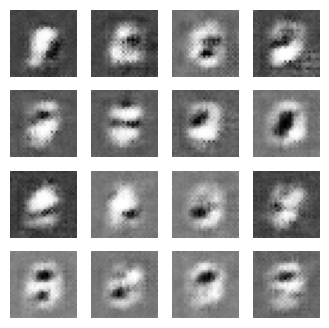

Epoch 6, Step 0, Gen Loss: 1.1291543245315552, Disc Loss: 0.7935556173324585
Epoch 6, Step 100, Gen Loss: 1.2797398567199707, Disc Loss: 0.7633746862411499


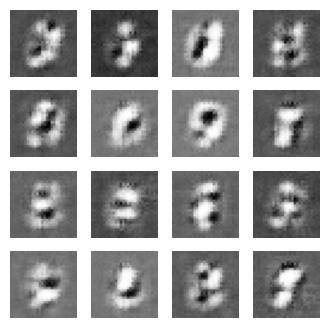

Epoch 7, Step 0, Gen Loss: 1.318901777267456, Disc Loss: 0.7730103731155396
Epoch 7, Step 100, Gen Loss: 1.28805410861969, Disc Loss: 0.6657730937004089


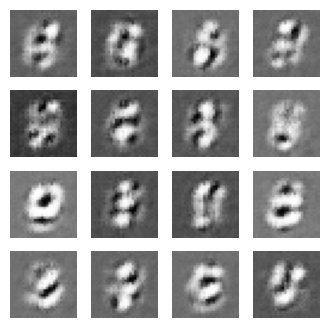

Epoch 8, Step 0, Gen Loss: 1.3092896938323975, Disc Loss: 0.7084609270095825
Epoch 8, Step 100, Gen Loss: 1.4194415807724, Disc Loss: 0.6329718232154846


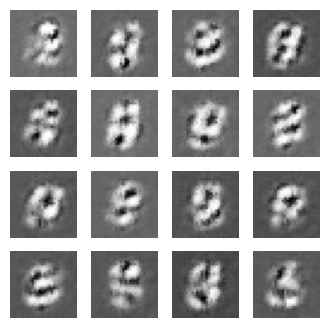

Epoch 9, Step 0, Gen Loss: 1.3842332363128662, Disc Loss: 0.6895831227302551
Epoch 9, Step 100, Gen Loss: 1.5551146268844604, Disc Loss: 0.5500917434692383


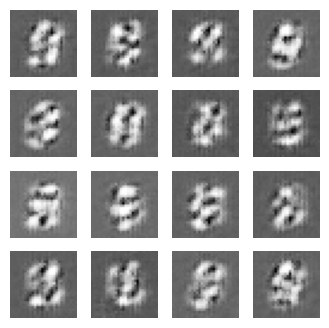

Epoch 10, Step 0, Gen Loss: 1.6557319164276123, Disc Loss: 0.5573891401290894
Epoch 10, Step 100, Gen Loss: 1.7088615894317627, Disc Loss: 0.441043883562088


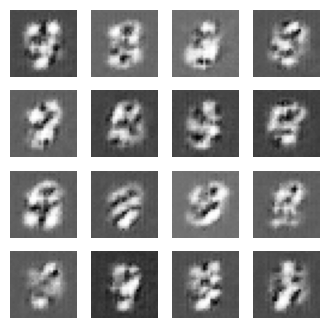

In [ ]:
 import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

# Load and preprocess MNIST dataset (using a smaller subset for faster testing)
def load_data():
    (x_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
    x_train = x_train[:10000]  # Use only 10,000 samples for faster testing
    x_train = x_train.astype('float32') / 255.0
    x_train = np.expand_dims(x_train, axis=-1)  # Add channel dimension
    return x_train

# Simplified Generator model
def build_generator():
    model = tf.keras.Sequential([
        layers.Input(shape=(100,)),  # Explicit Input Layer
        layers.Dense(7 * 7 * 128, use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Reshape((7, 7, 128)),

        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
    ])
    return model

# Simplified Discriminator model
def build_discriminator():
    model = tf.keras.Sequential([
        layers.Input(shape=(28, 28, 1)),  # Explicit Input Layer
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Flatten(),
        layers.Dense(1)
    ])
    return model

# Loss function
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

# Optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# Training the DCGAN
def train_step(generator, discriminator, images, batch_size=64):  # Reduced batch size
    noise = tf.random.normal([batch_size, 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

def train(generator, discriminator, dataset, epochs=10, batch_size=64):  # Reduced epochs and batch size
    for epoch in range(epochs):
        for step, image_batch in enumerate(dataset):
            gen_loss, disc_loss = train_step(generator, discriminator, image_batch, batch_size)

            if step % 100 == 0:  # Display progress every 100 batches
                print(f'Epoch {epoch + 1}, Step {step}, Gen Loss: {gen_loss}, Disc Loss: {disc_loss}')

        # Generate and save images at the end of each epoch
        generate_and_save_images(generator, epoch + 1)

# Function to generate and save images
def generate_and_save_images(model, epoch, test_input=None):
    if test_input is None:
        test_input = tf.random.normal([16, 100])
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
    plt.savefig(f'image_at_epoch_{epoch:04d}.png')
    plt.show()

# Main function
if __name__ == '__main__':
    BUFFER_SIZE = 10000  # Reduced buffer size due to reduced dataset
    BATCH_SIZE = 64  # Reduced batch size for faster training

    x_train = load_data()
    train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

    generator = build_generator()
    discriminator = build_discriminator()

    train(generator, discriminator, train_dataset, epochs=10)  # Reduced epochs
